In [1]:
!pip install roboflow torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
import sys
import numpy as np
import cv2
import os
from datetime import datetime
from PIL import Image
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as F
from roboflow import Roboflow
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
import glob as glob
import random
from pycocotools.coco import COCO
import yaml

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
print("We use the following device: ", device)

We use the following device:  cuda


## Dataset Download


In [4]:
rf = Roboflow(api_key="Ex8Yj8EiaKSeCDoNeUms")
project = rf.workspace("selfdriving-car-qtywx").project("self-driving-cars-lfjou")
version = project.version(4)
traffic_signs = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Self-Driving-Cars-4 in yolov11:: 100%|██████████| 9950/9950 [00:01<00:00, 8154.51it/s]


In [5]:
class TrafficDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.img_dir = os.path.join(root_dir, split, 'images')
        self.label_dir = os.path.join(root_dir, split, 'labels')

        self.img_files = [d for d in os.listdir(self.img_dir) if d.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        img_w, img_h = image.size

        label_name = '.'.join(img_name.split('.')[:3]) + ".txt"
        label_path = os.path.join(self.label_dir, label_name)

        boxes = []
        labels = []

        if not os.path.exists(label_path):
            raise RuntimeError(f"Label for image {img_path} ({label_path}) does not exists!")

        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                x_min = (x_center - width / 2) * img_w
                y_min = (y_center - height / 2) * img_h
                x_max = (x_center + width / 2) * img_w
                y_max = (y_center + height / 2) * img_h

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id)



        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Building targets
        # FasterRCNN needs, along with boxes and labels, fields
        # image_id, area, and iscrowd.
        if len(boxes) == 0:
          target = {
            "boxes": torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.zeros((0,), dtype=torch.int64),
            "image_id": torch.tensor([idx]),
            "area": torch.zeros((0,), dtype=torch.float32),
            "iscrowd": torch.zeros((0,), dtype=torch.int64)
          }
        else:
          target = {
              "boxes": boxes,
              "labels": labels,
              "image_id": torch.tensor([idx]),
              "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
              "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64),
          }

        if self.transform is not None:
            image = self.transform(image)

        return image, target

In [6]:
base_path = "Self-Driving-Cars-4"

train_path = "train"
valid_path = "valid"
test_path = "test"

In [7]:
with open(os.path.join(base_path, "data.yaml")) as f:
    dataset_config = yaml.safe_load(f)
    class_labels = dataset_config["names"]
    NUM_CLASSES = int(dataset_config['nc']) + 1

## Fine Tuning

In [8]:
SEED = 1926
NUM_EPOCHS = 5
LR = 0.005
LR_MOMENTUM = 0.9
LR_DECAY_RATE = 0.0005
LR_SCHED_STEP_SIZE = 0.1
LR_SCHED_GAMMA = 0.1
BATCH_SIZE = 8

torch.manual_seed(SEED)

In [37]:
from torchvision.transforms import v2 as T

def get_model():
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
    return model

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToImage())
    transforms.append(T.ToDtype(torch.float32, scale=True))
    return T.Compose(transforms)

In [10]:
if not os.path.exists("engine.py") \
    and not os.path.exists('utils.py') \
    and not os.path.exists("coco_utils.py") \
    and not os.path.exists("coco_eval.py") \
    and not os.path.exists("transforms.py"):

    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [39]:
def get_dataloaders():
    train_dataset = TrafficDataset(
        root_dir=base_path,
        split=train_path,
        transform=get_transform(train=True)
    )

    valid_dataset = TrafficDataset(
        root_dir=base_path,
        split=valid_path,
        transform=get_transform(train=False)
    )

    test_dataset = TrafficDataset(
        root_dir=base_path,
        split=test_path,
        transform=get_transform(train=False)
    )

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=8,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=True,
        collate_fn=lambda x: tuple(zip(*x))
    )

    return train_dataloader, valid_dataloader, test_dataloader

In [40]:
from engine import train_one_epoch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_d, valid_d, test_d = get_dataloaders()

model = get_model()
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LR,
    momentum=LR_MOMENTUM,
    weight_decay=LR_DECAY_RATE
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=LR_SCHED_STEP_SIZE,
    gamma=LR_SCHED_GAMMA
)
for epoch in range(NUM_EPOCHS):
    train_one_epoch(model, optimizer, train_d, device, epoch, print_freq=10)
    lr_scheduler.step()

print("Training complete!")

Epoch: [0]  [  0/442]  eta: 0:02:15  lr: 0.000016  loss: 3.5785 (3.5785)  loss_classifier: 2.7388 (2.7388)  loss_box_reg: 0.6467 (0.6467)  loss_objectness: 0.1441 (0.1441)  loss_rpn_box_reg: 0.0489 (0.0489)  time: 0.3058  data: 0.0299  max mem: 2009
Epoch: [0]  [ 10/442]  eta: 0:02:12  lr: 0.000130  loss: 2.9687 (3.1424)  loss_classifier: 2.6196 (2.6148)  loss_box_reg: 0.1949 (0.4125)  loss_objectness: 0.0908 (0.0800)  loss_rpn_box_reg: 0.0372 (0.0350)  time: 0.3074  data: 0.0311  max mem: 2009
Epoch: [0]  [ 20/442]  eta: 0:02:08  lr: 0.000243  loss: 2.5821 (2.5770)  loss_classifier: 2.2733 (2.1315)  loss_box_reg: 0.2060 (0.3430)  loss_objectness: 0.0638 (0.0695)  loss_rpn_box_reg: 0.0266 (0.0332)  time: 0.3039  data: 0.0314  max mem: 2009
Epoch: [0]  [ 30/442]  eta: 0:02:04  lr: 0.000356  loss: 1.5585 (2.1103)  loss_classifier: 1.0138 (1.6472)  loss_box_reg: 0.2876 (0.3630)  loss_objectness: 0.0476 (0.0689)  loss_rpn_box_reg: 0.0251 (0.0313)  time: 0.2998  data: 0.0308  max mem: 2009


In [33]:
torch.save(model.state_dict(), "fastrcnn_traffic_aug.pth")

In [41]:
from torchmetrics.detection import MeanAveragePrecision

def evaluate_model(model, dataloader, device):
  metric = MeanAveragePrecision(box_format="xyxy")
  model.eval()

  with torch.no_grad():
    for images, targets in tqdm(dataloader, desc="Evaluating model..."):
      images = [img.to(device) for img in images]
      predictions = model(images)

      preds = []
      trgts = []

      for pred, target in zip(predictions, targets):
        preds.append({
            'boxes': pred['boxes'].cpu(),
            'scores': pred['scores'].cpu(),
            'labels': pred['labels'].cpu(),
        })

        trgts.append({
            'boxes': target['boxes'].cpu(),
            'labels': target['labels'].cpu(),
        })

      metric.update(preds, trgts)

  results = metric.compute()

  print("\nDetection Metrics:")
  print(f"mAP (all classes): {results['map'].item():.4f}")
  print(f"mAP@.50 IoU: {results['map_50'].item():.4f}")
  print(f"mAP@.75 IoU: {results['map_75'].item():.4f}")
  print(f"mAP (small objects): {results['map_small'].item():.4f}")
  print(f"mAP (medium objects): {results['map_medium'].item():.4f}")
  print(f"mAP (large objects): {results['map_large'].item():.4f}")
  print(f"Average Recall (AR@1): {results['mar_1'].item():.4f}")
  print(f"Average Recall (AR@10): {results['mar_10'].item():.4f}")
  print(f"Average Recall (AR@100): {results['mar_100'].item():.4f}")

  return results

In [48]:
evaluate_model(model, valid_d, device)

Evaluating model...: 100%|██████████| 101/101 [00:16<00:00,  5.95it/s]



Detection Metrics:
mAP (all classes): 0.5505
mAP@.50 IoU: 0.7101
mAP@.75 IoU: 0.6668
mAP (small objects): 0.0558
mAP (medium objects): 0.4515
mAP (large objects): 0.6386
Average Recall (AR@1): 0.6434
Average Recall (AR@10): 0.6605
Average Recall (AR@100): 0.6607


{'map': tensor(0.5505),
 'map_50': tensor(0.7101),
 'map_75': tensor(0.6668),
 'map_small': tensor(0.0558),
 'map_medium': tensor(0.4515),
 'map_large': tensor(0.6386),
 'mar_1': tensor(0.6434),
 'mar_10': tensor(0.6605),
 'mar_100': tensor(0.6607),
 'mar_small': tensor(0.1448),
 'mar_medium': tensor(0.6059),
 'mar_large': tensor(0.7450),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        dtype=torch.int32)}

In [25]:
def load_model(weights_path: str, device):
  model = get_model()
  if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path))
    print(f"Model successfully loaded from {weights_path}")
  model.to(device)
  return model

model = load_model("fastrcnn_traffic.pth", device)

Model successfully loaded from fastrcnn_traffic.pth


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [51]:
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
import math


def visualise_detections(model, base_path: str, images: list[str],
                         device, score_threshold=0.5, images_per_row=4,
                         figsize=(20, 1600), bbox_color="red"):

    num_images = len(images)
    num_rows = math.ceil(num_images / images_per_row)

    plt.figure()

    transform = get_transform(train=False)

    model.eval()
    with torch.no_grad():
      for idx, img_path in enumerate(images):
        image = read_image(os.path.join(base_path, img_path))
        x = transform(image)
        x = x[:3, ...].to(device)

        predictions = model([x, ])
        pred = predictions[0]

        print(pred)

        mask = pred["scores"] > score_threshold
        filtered_boxes = pred['boxes'][mask].long()
        filtered_labels = pred['labels'][mask]
        filtered_scores = pred['scores'][mask]

        label_texts = [
            f"{class_labels[label.item()]} : {score:.2f}"
            for label, score in zip(filtered_labels, filtered_scores)
        ]

        image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
        image = image[:3, ...]

        if len(filtered_boxes) > 0:
          output_image = draw_bounding_boxes(
              image,
              filtered_boxes,
              label_texts,
              colors=bbox_color,
              width=5,
              font_size=2
          )
        else:
          output_image = image

        plt.imshow(output_image.permute(1, 2, 0))
        plt.axis('off')
        plt.show()


{'boxes': tensor([[470.7528, 142.3948, 617.5199, 298.4052],
        [471.9718, 139.4194, 617.3982, 307.4471],
        [477.4373, 156.9079, 623.2722, 291.8753],
        [465.8065, 126.7650, 613.4849, 300.6903]], device='cuda:0'), 'labels': tensor([12, 13, 10,  7], device='cuda:0'), 'scores': tensor([0.6970, 0.2164, 0.1838, 0.1513], device='cuda:0')}


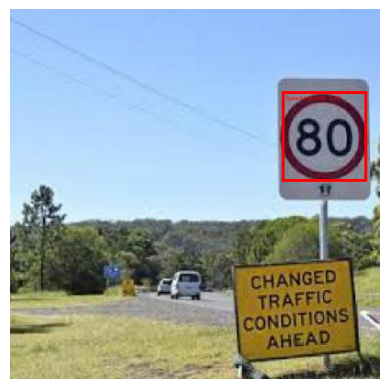

{'boxes': tensor([[214.0465, 267.1505, 345.7539, 364.1724]], device='cuda:0'), 'labels': tensor([8], device='cuda:0'), 'scores': tensor([0.8275], device='cuda:0')}


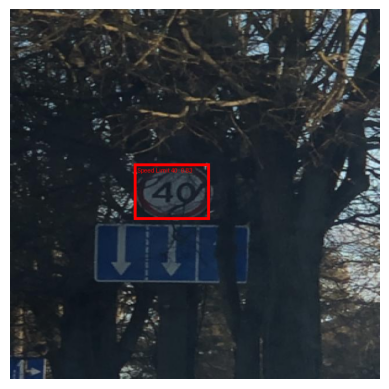

{'boxes': tensor([[169.4942, 336.8084, 451.7360, 511.0676],
        [166.8102, 329.1761, 450.1616, 517.2612],
        [173.8049, 336.8130, 456.0100, 516.3962]], device='cuda:0'), 'labels': tensor([ 8,  4, 11], device='cuda:0'), 'scores': tensor([0.9559, 0.0797, 0.0600], device='cuda:0')}


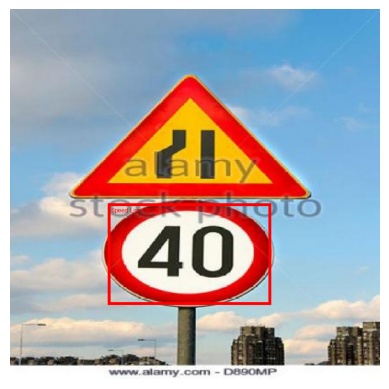

{'boxes': tensor([[277.7065,   3.3082, 302.9213,  97.4803],
        [279.5392,   7.3217, 294.6241,  81.6114],
        [432.2040, 156.3476, 457.1965, 251.1091],
        [442.5041, 158.3532, 465.2049, 250.8541],
        [280.3085,  13.4893, 298.8636,  49.4748],
        [279.1221, 115.3714, 297.6589, 146.0659],
        [277.2001,  33.2840, 293.7853,  92.7284]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8218, 0.3189, 0.2912, 0.1323, 0.0885, 0.0751, 0.0653],
       device='cuda:0')}


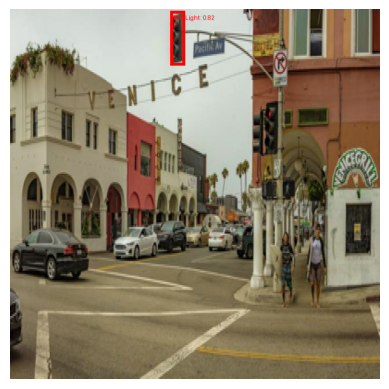

{'boxes': tensor([[210.3329,  66.8994, 223.8307, 122.4915],
        [524.0974, 151.7441, 538.8464, 199.5661],
        [207.5823,  65.0012, 216.1578, 126.0395],
        [349.8477,  55.9395, 368.3739, 106.8968],
        [519.6261, 152.8949, 528.1054, 199.9108],
        [214.2480,  68.7488, 228.2847, 114.9821],
        [355.6039,  58.0438, 386.7274, 104.4067],
        [202.1501,  68.0083, 212.7306, 126.2775],
        [526.8124, 151.6120, 542.8486, 184.4146],
        [337.0732,  54.9509, 354.4446, 108.3641],
        [218.2934,  64.7737, 231.5044, 122.7321],
        [514.5431, 152.4985, 525.1875, 202.0125]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7578, 0.6581, 0.6335, 0.5355, 0.4220, 0.2062, 0.1469, 0.1175, 0.0947,
        0.0566, 0.0538, 0.0537], device='cuda:0')}


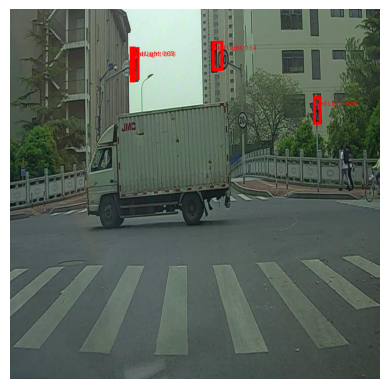

{'boxes': tensor([[167.7961, 148.2150, 513.2449, 529.8088],
        [148.5492, 161.7309, 499.6738, 504.9431],
        [177.3196, 159.3198, 521.0377, 515.0765],
        [157.0951, 155.5240, 517.5441, 512.6918],
        [165.8315, 147.0414, 520.3607, 511.0906],
        [167.5126, 163.8159, 509.4563, 497.0787]], device='cuda:0'), 'labels': tensor([ 3,  5, 11, 12,  9, 10], device='cuda:0'), 'scores': tensor([0.5501, 0.4796, 0.2060, 0.1480, 0.0552, 0.0511], device='cuda:0')}


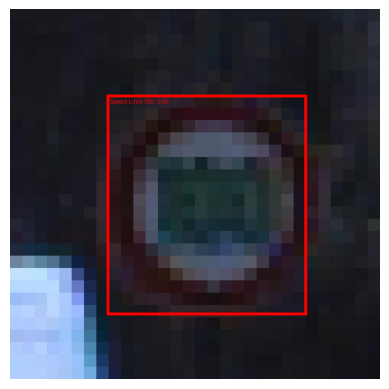

{'boxes': tensor([[401.9421,  69.2923, 603.7621, 339.0298],
        [402.2289,  41.4561, 614.2936, 343.9539],
        [403.1346,  81.7360, 614.9259, 320.3807],
        [406.9164,  62.4418, 602.0626, 338.3092]], device='cuda:0'), 'labels': tensor([12, 13, 10,  7], device='cuda:0'), 'scores': tensor([0.8372, 0.1498, 0.1207, 0.0675], device='cuda:0')}


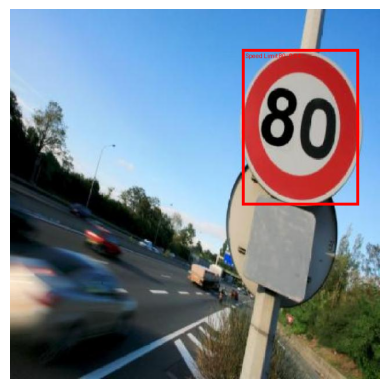

{'boxes': tensor([[171.4078, 169.8327, 486.8349, 537.6835],
        [174.0916, 176.0547, 499.5295, 531.7608],
        [169.8714, 180.2863, 518.9037, 539.1782]], device='cuda:0'), 'labels': tensor([7, 6, 9], device='cuda:0'), 'scores': tensor([0.5295, 0.4854, 0.2641], device='cuda:0')}


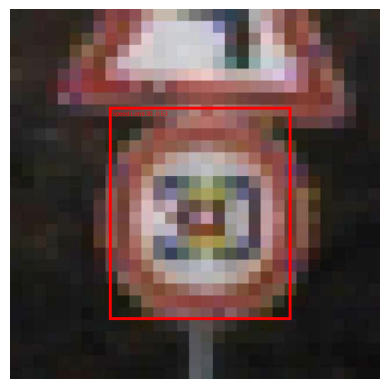

{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}


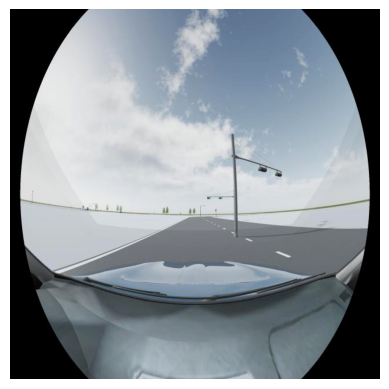

{'boxes': tensor([[114.5834, 205.6404, 302.1552, 470.1665],
        [119.9666, 220.5804, 301.9754, 478.3374],
        [112.8625, 201.7137, 306.9762, 474.3215],
        [125.6899, 204.4803, 294.9272, 469.6436],
        [338.7357, 219.4154, 539.7856, 454.3541],
        [343.8536, 222.3465, 543.5547, 450.8057],
        [345.8662, 215.5308, 540.5384, 448.0193],
        [128.0937, 216.4562, 305.9402, 477.0128]], device='cuda:0'), 'labels': tensor([ 4,  3,  5,  8,  3,  4, 12, 11], device='cuda:0'), 'scores': tensor([0.5369, 0.4496, 0.1710, 0.0825, 0.0792, 0.0676, 0.0626, 0.0626],
       device='cuda:0')}


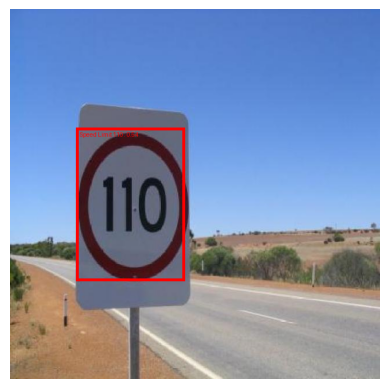

{'boxes': tensor([[409.3384,  72.7935, 517.0811, 211.5989],
        [414.5511,  75.0146, 519.7065, 218.7303],
        [412.3340,  69.9945, 513.8464, 215.4819],
        [412.3681,  74.5584, 517.1345, 211.9943],
        [418.1682,  85.7908, 519.2480, 208.0876]], device='cuda:0'), 'labels': tensor([12, 13,  7,  9, 10], device='cuda:0'), 'scores': tensor([0.3220, 0.2319, 0.2036, 0.1963, 0.1936], device='cuda:0')}


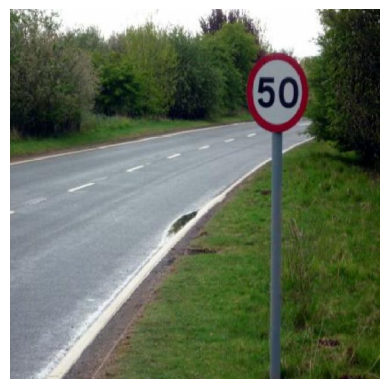

{'boxes': tensor([[ 66.7066,  81.9110, 590.2040, 569.4268],
        [ 57.0661,  70.0482, 615.3353, 586.8776]], device='cuda:0'), 'labels': tensor([11,  9], device='cuda:0'), 'scores': tensor([0.9733, 0.0658], device='cuda:0')}


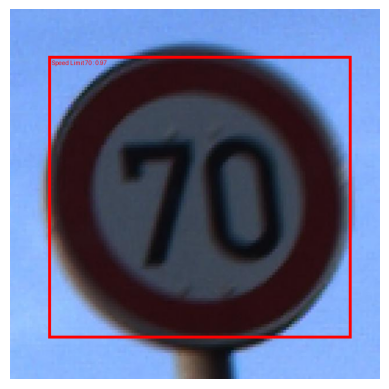

{'boxes': tensor([[286.9547, 274.2386, 372.9272, 346.0032],
        [284.1374, 271.9098, 366.4548, 342.4756],
        [226.7283, 268.7942, 341.3395, 348.5542],
        [288.6136, 270.5472, 371.5125, 344.2737],
        [287.2612, 278.0249, 373.3934, 342.7095]], device='cuda:0'), 'labels': tensor([ 8,  7,  8,  9, 11], device='cuda:0'), 'scores': tensor([0.5479, 0.3196, 0.0641, 0.0611, 0.0521], device='cuda:0')}


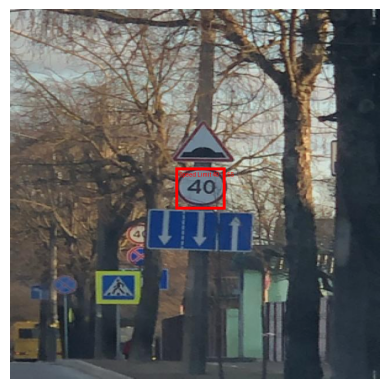

{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}


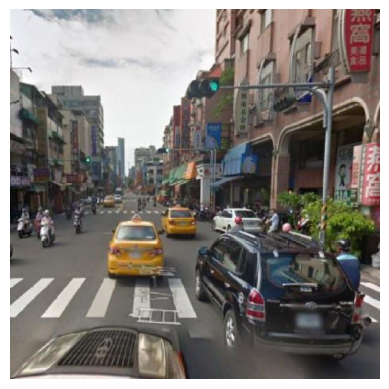

{'boxes': tensor([[244.6150, 268.9706, 360.0323, 362.1535],
        [ 82.7213, 432.0178, 135.1147, 477.1067],
        [ 79.9411, 431.1992, 138.7883, 479.0218],
        [206.3461, 261.3921, 323.2152, 361.2581],
        [ 81.4765, 433.0857, 137.5789, 475.5016],
        [248.3143, 265.0222, 363.3799, 363.8415],
        [ 83.6847, 432.5308, 139.2219, 477.4024]], device='cuda:0'), 'labels': tensor([ 8,  7,  8,  8, 12,  7, 13], device='cuda:0'), 'scores': tensor([0.9263, 0.2188, 0.1967, 0.0997, 0.0991, 0.0785, 0.0531],
       device='cuda:0')}


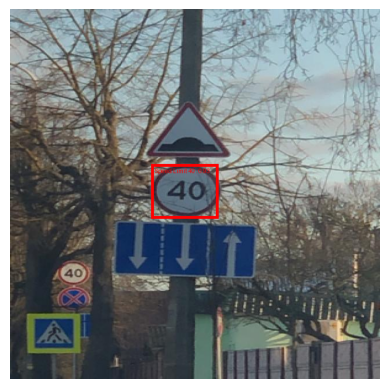

{'boxes': tensor([[169.6185, 113.9261, 454.8419, 502.8202],
        [165.2401, 113.9412, 447.0549, 484.1729],
        [157.8297,  96.5184, 445.6443, 495.0205],
        [181.4857, 101.3304, 452.0222, 478.6825],
        [162.5130,  82.7075, 434.3081, 472.9451]], device='cuda:0'), 'labels': tensor([ 3,  4,  5, 11,  8], device='cuda:0'), 'scores': tensor([0.4278, 0.3604, 0.3563, 0.1412, 0.1263], device='cuda:0')}


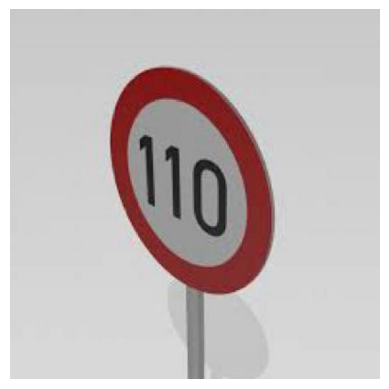

{'boxes': tensor([[ 79.0763,  95.3902, 568.3968, 593.7609],
        [ 70.1722,  90.5605, 574.1026, 550.9851],
        [ 98.3816,  88.8090, 587.4230, 561.9671]], device='cuda:0'), 'labels': tensor([ 3,  5, 12], device='cuda:0'), 'scores': tensor([0.8341, 0.3095, 0.0607], device='cuda:0')}


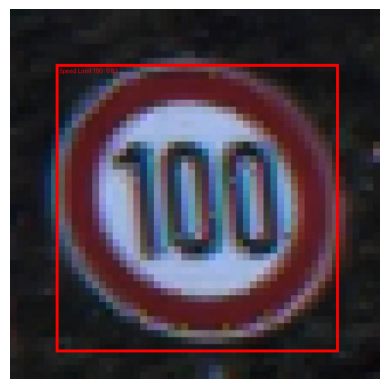

{'boxes': tensor([[ 77.0994,  57.8742, 614.7121, 588.8538]], device='cuda:0'), 'labels': tensor([6], device='cuda:0'), 'scores': tensor([0.9906], device='cuda:0')}


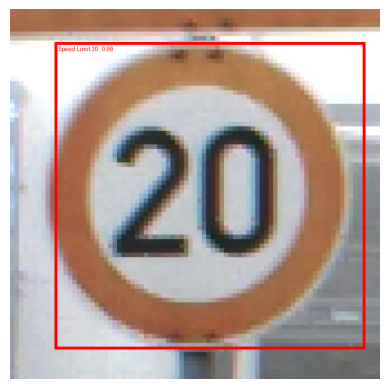

{'boxes': tensor([[102.8582, 105.3781, 550.2078, 598.0625],
        [ 76.9174,  95.6776, 562.8591, 570.2707],
        [110.2560,  95.5859, 568.3758, 571.9904]], device='cuda:0'), 'labels': tensor([ 3,  5, 12], device='cuda:0'), 'scores': tensor([0.9080, 0.2608, 0.0606], device='cuda:0')}


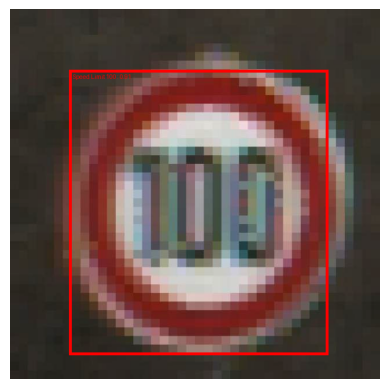

{'boxes': tensor([[127.2110, 152.9642, 510.9858, 531.8979],
        [152.8944, 143.7435, 538.0476, 535.2701],
        [125.7936, 147.3885, 515.6114, 506.3366]], device='cuda:0'), 'labels': tensor([ 5, 11, 10], device='cuda:0'), 'scores': tensor([0.8972, 0.1061, 0.0503], device='cuda:0')}


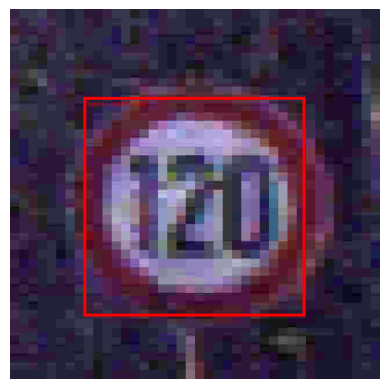

In [52]:
images = os.listdir(os.path.join(base_path, test_path, "images"))[:20]
visualise_detections(model, os.path.join(base_path, "test", "images"), images, device)

## Object Tracking

We use the already defined `compute_iou` in order to compute Intersection Over of the detected bounding boxes.

In [54]:
class FastRCNNDetector:
    def __init__(self, model, device, input_transf=None):
        self.model = model
        self.input_transf = input_transf
        self.device = device

    def detect_single_frame(self, frame, score_threshold = 0.5):
        """
        Args:
            frame: a frame loaded with opencv as a numpy array representing the read frame.
            score_threshold: float representing filtering threshold for yielded predictions.
        """
        self.model.to(self.device)
        self.model.eval()
        with torch.no_grad():
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame) # Need image as Pil Format for FastRCNN Pipeline
            if self.input_transf is not None:
                frame = self.input_transf(frame)
            frame = frame[:3, ...].to(self.device)

            predictions = model([frame, ])
            pred = predictions[0]

            mask = pred['scores'] > score_threshold
            filtered_boxes = pred['boxes'][mask].long()
            filtered_labels = pred['labels'][mask]
            
            return zip(filtered_boxes, filtered_labels)

tensor([174, 109, 455, 506], device='cuda:0')


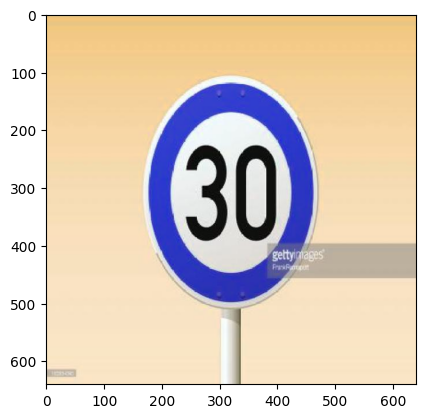

In [63]:
detector = FastRCNNDetector(model, device, get_transform(train=False))

image = cv2.imread("/kaggle/working/Self-Driving-Cars-4/test/images/000003_jpg.rf.b1ed2f93a95ea734198b82e993029867.jpg")
plt.imshow(image)
for item in detector.detect_single_frame(image):
    print(item)

In [81]:
torch.cat((item[0], item[1].unsqueeze(0)), dim=0)

tensor([174, 109, 455, 506,   7], device='cuda:0')

In [50]:
def compute_iou(bb1: list, bb2: list):
  bb1_x1=bb1[0]
  bb1_y1=bb1[1]
  bb1_x2=bb1[2]
  bb1_y2=bb1[3]

  bb2_x1=bb2[0]
  bb2_y1=bb2[1]
  bb2_x2=bb2[2]
  bb2_y2=bb2[3]

  x_left = max(bb1_x1, bb2_x1)
  y_top = max(bb1_y1, bb2_y1)
  x_right = min(bb1_x2, bb2_x2)
  y_bottom = min(bb1_y2, bb2_y2)

  if x_right < x_left or y_bottom < y_top:
    return 0.0

  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  bb1_area = (bb1_x2 - bb1_x1) * (bb1_y2 - bb1_y1)
  bb2_area = (bb2_x2 - bb2_x1) * (bb2_y2 - bb2_y1)

  iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou

In [ ]:
class OjbectTracker:
    def __init__(self, iou_threshol=0.5):
        self.iou_threshold = iou_threshold
        self.tracked_objects = {}
        self.next_object_id = 0

    def update(self, detections: list):
        updated_tracked_objects = {}
        assigned_detections = set()

        for obj_id, prev_bbox in self.tracked_objects.items():
            best_iou = 0
            best_det_idx = -1

            for idx, det_bbox in enumerate(detections):
                if idx in assigned_detections:
                    continue
                iou = compute_iou(prev_bbox[0], det_bbox[0])
                if iou > best_iou and iou >= self.iou_threshold:
                    best_iou = iou
                    best_det_idx = idx

            if best_det_idx != -1:
                updated_tracked_objects[obj_id] = detections[best_det_idx]
                assigned_detections.add(best_det_idx)

        # Add new detections as new objects
        for idx, det_bbox in enumerate(detections):
            if idx not in assigned_detections:
                updated_tracked_objects[self.next_object_id] = det_bbox
                self.next_object_id += 1

        # Update the tracked objects
        self.tracked_objects = updated_tracked_objects
        return self.tracked_objects